In [1]:
import numpy as np
from scipy.linalg import expm
import pandas as pd
from scipy.sparse import diags

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

# Set the font to Times New Roman for the whole plot
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

## Functions

In [2]:
# Optimal controls
def optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y,
                     S,z_2,delta_a_2,delta_b_2):
    
    K=k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, S, z_2, delta_a_2, delta_b_2)
    w=W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t, T)
    
    
    h1_1st=h1_function(zeta,kappa1,w,y,Y_1);
    h1_2nd=h1_function(zeta,kappa1,w,y+zeta,Y_1);
    h1_3rd=h1_function(zeta,kappa1,w,y-zeta,Y_1);
    z= m2_1/(y**2);
    delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
    delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)
    return delta_b_star, delta_a_star

In [3]:
# Level functions and derivative
def lvlfct(m_2, y):
    return m_2/y;

def lvlfct_deriv(m_2,y):
    return -m_2/y**2

In [4]:
# h1 and H1
def h1_function(zeta, kappa, w, y, Y_1):
    # Find entries in w where Y_1 matches y
    w=np.sqrt(w)
    matched_w = w[Y_1 == y]
    # Check if the matched_w array is empty
    if matched_w.size == 0:
        return np.nan  # Return np.nan if y is not found in Y_1
    else:
        # Calculate h1 if there is at least one match
        h1 = (zeta / kappa) * np.log(matched_w.item())  # Assuming only one match; use matched_w[0] if multiple matches are handled differently
        return h1
    
def H1_function(x,y,S,h1):
    H1=x+y*S+h1
    return H1

In [5]:
# W_t
def W_t_function(alpha1, kappa1, zeta, Y_1, hat_y1, K, t, T):
    exponent_values = -alpha1 * kappa1 / zeta * (Y_1 - hat_y1)**2
    W0 = (np.exp(exponent_values)) **2
    W_t = expm(K * (T-t)).dot(W0)
    return W_t

In [6]:
# K matrix
def k_matrix(N_1, lambda_a, lambda_b, phi1, kappa1, Y_1, hat_y1, S, z_2, delta_a_2, delta_b_2):
    # The main diagonal values
    main_diag = -2 * kappa1 * phi1 * (Y_1 - hat_y1)**2 / zeta

    # Subdiagonal and superdiagonal values
    sub_diag = lambda_a * np.exp(-kappa1 * S + kappa1 * z_2 + kappa1 * delta_a_2 - 1) * np.ones(N_1)  
    super_diag = lambda_b * np.exp(kappa1 * S - kappa1 * z_2 + kappa1 * delta_b_2 - 1) * np.ones(N_1)

    # Create the tridiagonal sparse matrix
    diagonals = [sub_diag, main_diag, super_diag]
    K = diags(diagonals, offsets=[-1, 0, 1], shape=(N_1+1, N_1+1), format='csr')
    
    return K.todense()

## Parameters and initial assumptions

In [7]:
# AMM default parameters (Table 6.2)
zeta = 1 # Trading size [units of y]
T = 30 # Trading window [seconds]
lambda_a = 1 # Baseline sell order arrival intensity [order/second]
lambda_b = 1 # Baseline buy order arrival intensity [order/second]

In [8]:
# Liquidity providers default characteristics (Table 6.1)
x0_1=1 # Initial x reserve for LP1
y0_1=1 # Initial y reserve for LP1
z0_1=x0_1/y0_1 # Initial marginal rate z for LP1
m2_1=x0_1*y0_1 # Liquidity depth measure for LP1

y_min_1 = -3 # Y lower reserve constraint for LP1
y_max_1 = 3 # Y upper reserve constraint for LP1
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)
Z_1 = m2_1 / (Y_1 ** 2 + 1e-10)  # Adding a small constant to avoid division by zero

phi1 = 10**(-5) # Inventory penalty for LP1
alpha1 = 0.001 # Terminal penalty for LP1
kappa1= 10 # Rate of order pressure decay for LP1
hat_y1 = 0 # Inventory objective for LP1

z_2=z0_1 # Initial marginal rate z for LP2
delta_a_2=0.1 # Arbritrary constant sell depth for LP2
delta_b_2=0.1 # Arbritrary constant buy depth for LP2

In [9]:
# LOB setting
S=x0_1/y0_1 # Fundamental asset rate (assumed equal to initial marginal rate at time 0)
sigma=0.01 # Asset volatility

## Simulations

In [10]:
delta_a_2=0.5;
delta_b_2=0.5;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_1[i,j], delta_a_star_1[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

/Users/alexisaber/anaconda3/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_9504/2508092725.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_9504/2508092725.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)


In [11]:
phi11 = np.linspace(10**(-1),10**(-5)) # No inventory penalty
t=t_grid[76]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, phi in enumerate(phi11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [12]:
alpha11 = np.linspace(10**(-1),10**(-3)) # No terminal penalty
t=t_grid[-1]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, alpha in enumerate(alpha11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_3[i,j], delta_a_star_3[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [13]:
kappa11= np.linspace(1,30)
t=t_grid[5]
y_test_range=[-3,-2,-1,1,2,3]
delta_b_star_4 = np.zeros((len(y_test_range),len(kappa11)))
delta_a_star_4 = np.zeros((len(y_test_range),len(kappa11)))
for i,y_test in enumerate(y_test_range):
    for j, kappa in enumerate(kappa11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_4[i,j], delta_a_star_4[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_9504/2508092725.py:16: RuntimeWarning: invalid value encountered in scalar subtract
  delta_b_star = (1 / (2 * kappa1)) + (h1_1st - h1_2nd) / zeta + (z - S)
/var/folders/xb/48h8lf4d3h70nx9v468g5yj40000gn/T/ipykernel_9504/2508092725.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  delta_a_star = (1 / (2 * kappa1)) + (h1_1st - h1_3rd) / zeta + (S - z)


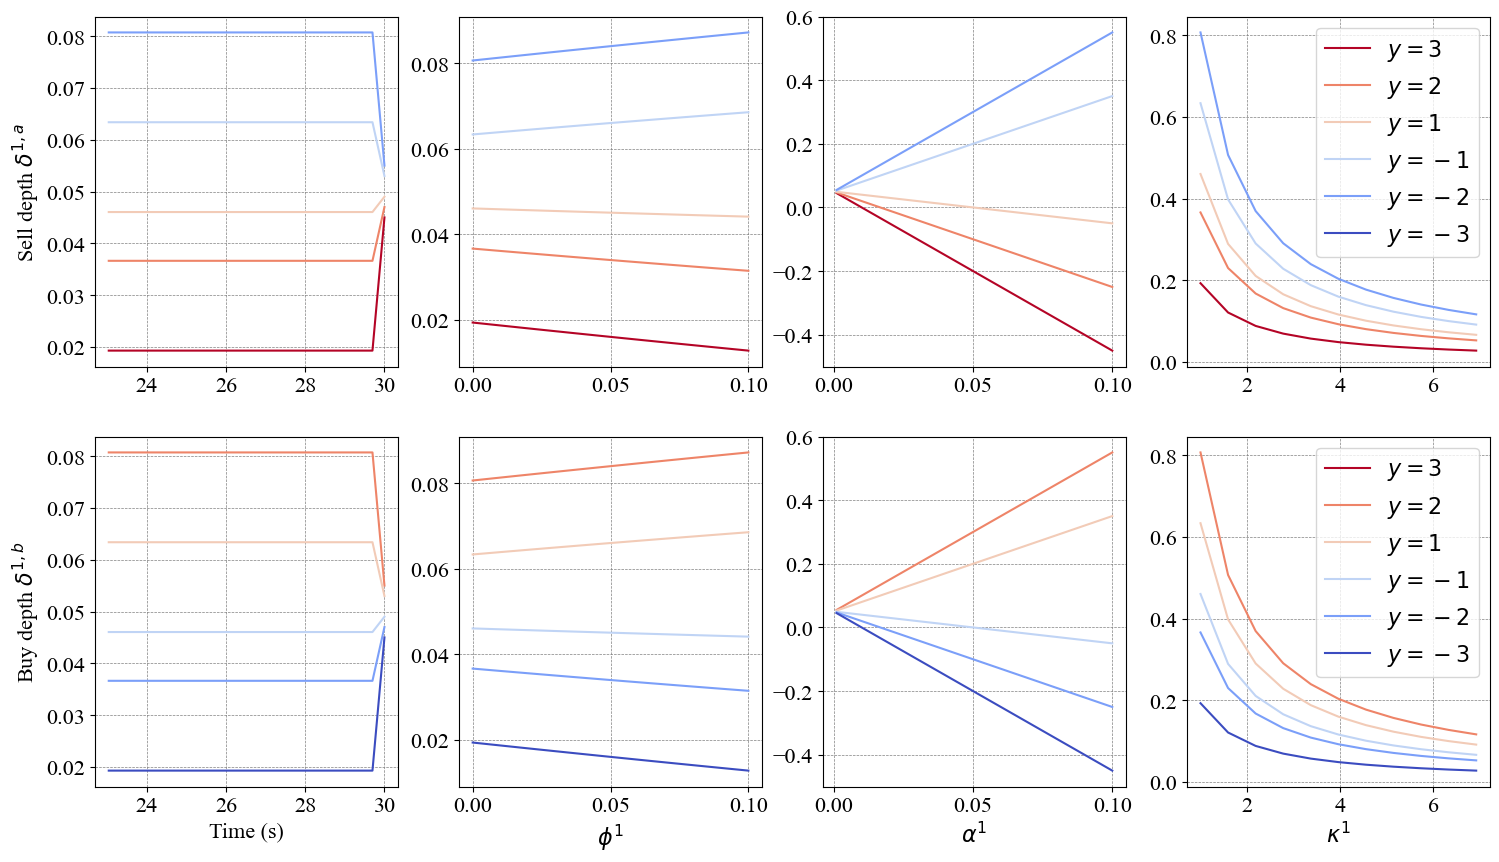

In [18]:
# Update the font size
plt.rcParams.update({'font.size': 16})

# Create a colormap with a range of colors from red to blue
colors = plt.cm.coolwarm(np.linspace(0, 1, 6))

# Figure setup
plt.figure(figsize=(18, 10))

# First subplot
plt.subplot(2, 4, 1)
plt.plot(t_grid, delta_a_star_1[5, :], color=colors[5], label='$y=3$')
plt.plot(t_grid, delta_a_star_1[4, :], color=colors[4], label='$y=2$')
plt.plot(t_grid, delta_a_star_1[3, :], color=colors[3], label='$y=1$')
plt.plot(t_grid, delta_a_star_1[2, :], color=colors[2], label='$y=-1$')
plt.plot(t_grid, delta_a_star_1[1, :], color=colors[1], label='$y=-2$')
plt.plot(t_grid, delta_a_star_1[0, :], color=colors[0], label='$y=-3$')
plt.ylabel(r'Sell depth $\delta^{1,a}$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Second subplot
plt.subplot(2, 4, 5)
plt.plot(t_grid, delta_b_star_1[5, :], color=colors[5], label='$y=3$')
plt.plot(t_grid, delta_b_star_1[4, :], color=colors[4], label='$y=2$')
plt.plot(t_grid, delta_b_star_1[3, :], color=colors[3], label='$y=1$')
plt.plot(t_grid, delta_b_star_1[2, :], color=colors[2], label='$y=-1$')
plt.plot(t_grid, delta_b_star_1[1, :], color=colors[1], label='$y=-2$')
plt.plot(t_grid, delta_b_star_1[0, :], color=colors[0], label='$y=-3$')
plt.xlabel('Time (s)')
plt.ylabel(r'Buy depth $\delta^{1,b}$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Third subplot
plt.subplot(2, 4, 2)
plt.plot(phi11, delta_a_star_2[5, :], color=colors[5], label='$y=3$')
plt.plot(phi11, delta_a_star_2[4, :], color=colors[4], label='$y=2$')
plt.plot(phi11, delta_a_star_2[3, :], color=colors[3], label='$y=1$')
plt.plot(phi11, delta_a_star_2[2, :], color=colors[2], label='$y=-1$')
plt.plot(phi11, delta_a_star_2[1, :], color=colors[1], label='$y=-2$')
plt.plot(phi11, delta_a_star_2[0, :], color=colors[0], label='$y=-3$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Fourth subplot
plt.subplot(2, 4, 6)
plt.plot(phi11, delta_b_star_2[5, :], color=colors[5], label='$y=3$')
plt.plot(phi11, delta_b_star_2[4, :], color=colors[4], label='$y=2$')
plt.plot(phi11, delta_b_star_2[3, :], color=colors[3], label='$y=1$')
plt.plot(phi11, delta_b_star_2[2, :], color=colors[2], label='$y=-1$')
plt.plot(phi11, delta_b_star_2[1, :], color=colors[1], label='$y=-2$')
plt.plot(phi11, delta_b_star_2[0, :], color=colors[0], label='$y=-3$')
plt.xlabel('$\\phi^1$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Fifth subplot
plt.subplot(2, 4, 3)
plt.plot(alpha11, delta_a_star_3[5, :], color=colors[5], label='$y=3$')
plt.plot(alpha11, delta_a_star_3[4, :], color=colors[4], label='$y=2$')
plt.plot(alpha11, delta_a_star_3[3, :], color=colors[3], label='$y=1$')
plt.plot(alpha11, delta_a_star_3[2, :], color=colors[2], label='$y=-1$')
plt.plot(alpha11, delta_a_star_3[1, :], color=colors[1], label='$y=-2$')
plt.plot(alpha11, delta_a_star_3[0, :], color=colors[0], label='$y=-3$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Sixth subplot
plt.subplot(2, 4, 7)
plt.plot(alpha11, delta_b_star_3[5, :], color=colors[5], label='$y=3$')
plt.plot(alpha11, delta_b_star_3[4, :], color=colors[4], label='$y=2$')
plt.plot(alpha11, delta_b_star_3[3, :], color=colors[3], label='$y=1$')
plt.plot(alpha11, delta_b_star_3[2, :], color=colors[2], label='$y=-1$')
plt.plot(alpha11, delta_b_star_3[1, :], color=colors[1], label='$y=-2$')
plt.plot(alpha11, delta_b_star_3[0, :], color=colors[0], label='$y=-3$')
plt.xlabel('$\\alpha^1$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Seventh subplot
plt.subplot(2, 4, 4)
plt.plot(kappa11, delta_a_star_4[5, :], color=colors[5], label='$y=3$')
plt.plot(kappa11, delta_a_star_4[4, :], color=colors[4], label='$y=2$')
plt.plot(kappa11, delta_a_star_4[3, :], color=colors[3], label='$y=1$')
plt.plot(kappa11, delta_a_star_4[2, :], color=colors[2], label='$y=-1$')
plt.plot(kappa11, delta_a_star_4[1, :], color=colors[1], label='$y=-2$')
plt.plot(kappa11, delta_a_star_4[0, :], color=colors[0], label='$y=-3$')
plt.legend(loc='upper right')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Eighth subplot
plt.subplot(2, 4, 8)
plt.plot(kappa11, delta_b_star_4[5, :], color=colors[5], label='$y=3$')
plt.plot(kappa11, delta_b_star_4[4, :], color=colors[4], label='$y=2$')
plt.plot(kappa11, delta_b_star_4[3, :], color=colors[3], label='$y=1$')
plt.plot(kappa11, delta_b_star_4[2, :], color=colors[2], label='$y=-1$')
plt.plot(kappa11, delta_b_star_4[1, :], color=colors[1], label='$y=-2$')
plt.plot(kappa11, delta_b_star_4[0, :], color=colors[0], label='$y=-3$')
plt.legend(loc='upper right')
plt.xlabel('$\\kappa^1$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Apply font settings
plt.xticks(fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')

# Save the figure
plt.savefig('Figure-6-1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
S_change=np.linspace(0.8,1.2)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_6 = np.zeros((len(y_test_range),len(S_change)))
delta_a_star_6 = np.zeros((len(y_test_range),len(S_change)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, S_delta in enumerate(S_change):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test*S_delta
        
        delta_b_star_6[i,j], delta_a_star_6[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2_test,delta_a_2,delta_b_2)

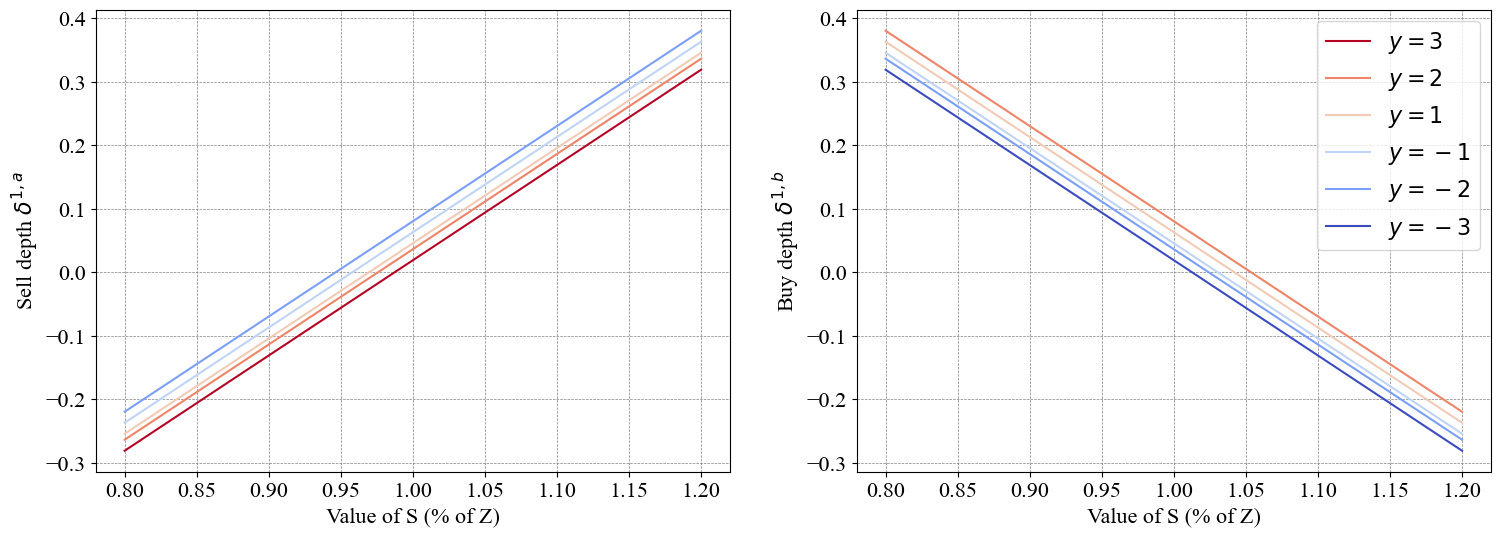

In [20]:
# Update the font size
plt.rcParams.update({'font.size': 16})

# Create a colormap with a range of colors from red to blue
colors = plt.cm.coolwarm(np.linspace(0, 1, 6))

# Figure setup
plt.figure(figsize=(18, 6))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(S_change, delta_a_star_6[5, :], color=colors[5], label='$y=3$')
plt.plot(S_change, delta_a_star_6[4, :], color=colors[4], label='$y=2$')
plt.plot(S_change, delta_a_star_6[3, :], color=colors[3], label='$y=1$')
plt.plot(S_change, delta_a_star_6[2, :], color=colors[2], label='$y=-1$')
plt.plot(S_change, delta_a_star_6[1, :], color=colors[1], label='$y=-2$')
plt.plot(S_change, delta_a_star_6[0, :], color=colors[0], label='$y=-3$')
plt.xlabel('Value of S (% of Z)')
plt.ylabel('Sell depth $\delta^{1,a}$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(S_change, delta_b_star_6[5, :], color=colors[5], label='$y=3$')
plt.plot(S_change, delta_b_star_6[4, :], color=colors[4], label='$y=2$')
plt.plot(S_change, delta_b_star_6[3, :], color=colors[3], label='$y=1$')
plt.plot(S_change, delta_b_star_6[2, :], color=colors[2], label='$y=-1$')
plt.plot(S_change, delta_b_star_6[1, :], color=colors[1], label='$y=-2$')
plt.plot(S_change, delta_b_star_6[0, :], color=colors[0], label='$y=-3$')
plt.legend()
plt.xlabel('Value of S (% of Z)')
plt.ylabel('Buy depth $\delta^{1,b}$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Save the figure
plt.savefig('Varying_value_of_S_Model_1_a.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
Z_change=np.linspace(0.8,1.2)

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star = np.zeros((len(y_test_range),len(Z_change)))
delta_a_star = np.zeros((len(y_test_range),len(Z_change)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, Z_delta in enumerate(Z_change):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_22_test=z_test * Z_delta
        Snew=z_test
        
        delta_b_star[i,j], delta_a_star[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     Snew,z_22_test,delta_a_2,delta_b_2)

In [22]:
delta_a_2=0.01;
delta_b_2=0.01;
Z_change=np.linspace(0.8,1.2)

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[80]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_Z = np.zeros((len(y_test_range),len(Z_change)))
delta_a_star_Z = np.zeros((len(y_test_range),len(Z_change)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, Z_delta in enumerate(Z_change):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_22_test=z_test * Z_delta
        Snew=z_test
        
        delta_b_star_Z[i,j], delta_a_star_Z[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     Snew,z_22_test,delta_a_2,delta_b_2)

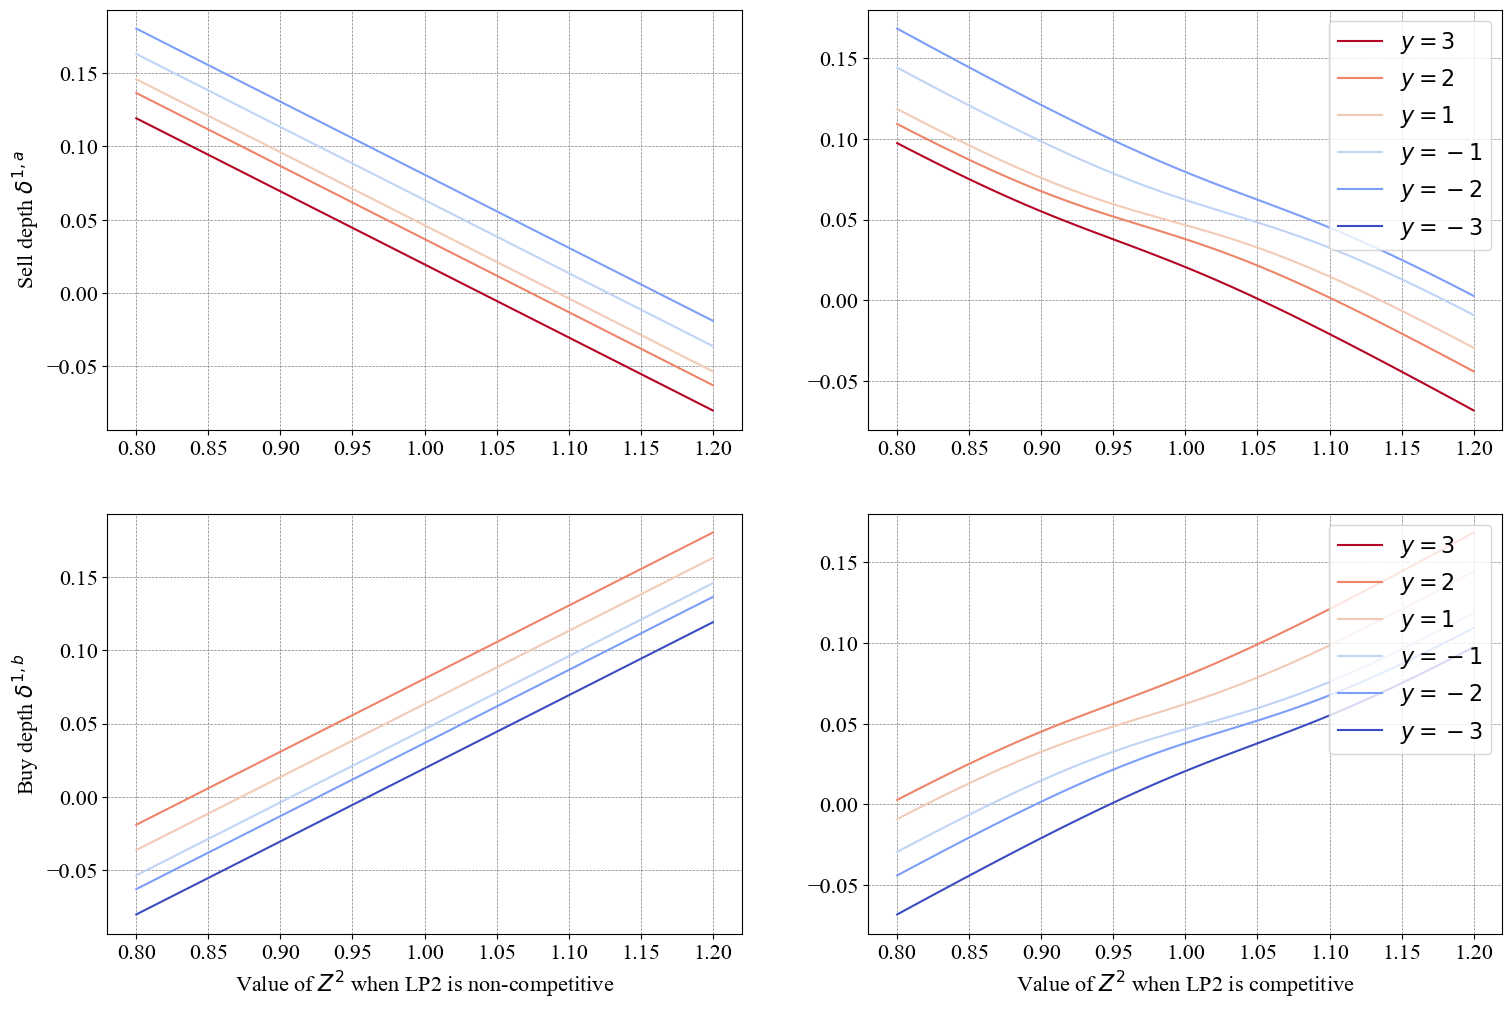

In [23]:
# Update the font size
plt.rcParams.update({'font.size': 16})

# Create a colormap with a range of colors from red to blue
colors = plt.cm.coolwarm(np.linspace(0, 1, 6))

# Figure setup
plt.figure(figsize=(18, 12))

# First subplot
plt.subplot(2, 2, 1)
plt.plot(Z_change, delta_a_star[5, :], color=colors[5], label='$y=3$')
plt.plot(Z_change, delta_a_star[4, :], color=colors[4], label='$y=2$')
plt.plot(Z_change, delta_a_star[3, :], color=colors[3], label='$y=1$')
plt.plot(Z_change, delta_a_star[2, :], color=colors[2], label='$y=-1$')
plt.plot(Z_change, delta_a_star[1, :], color=colors[1], label='$y=-2$')
plt.plot(Z_change, delta_a_star[0, :], color=colors[0], label='$y=-3$')
plt.ylabel('Sell depth $\delta^{1,a}$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Second subplot
plt.subplot(2, 2, 2)
plt.plot(Z_change, delta_a_star_Z[5, :], color=colors[5], label='$y=3$')
plt.plot(Z_change, delta_a_star_Z[4, :], color=colors[4], label='$y=2$')
plt.plot(Z_change, delta_a_star_Z[3, :], color=colors[3], label='$y=1$')
plt.plot(Z_change, delta_a_star_Z[2, :], color=colors[2], label='$y=-1$')
plt.plot(Z_change, delta_a_star_Z[1, :], color=colors[1], label='$y=-2$')
plt.plot(Z_change, delta_a_star_Z[0, :], color=colors[0], label='$y=-3$')
plt.legend(loc='upper right')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Third subplot
plt.subplot(2, 2, 3)
plt.plot(Z_change, delta_b_star[5, :], color=colors[5], label='$y=3$')
plt.plot(Z_change, delta_b_star[4, :], color=colors[4], label='$y=2$')
plt.plot(Z_change, delta_b_star[3, :], color=colors[3], label='$y=1$')
plt.plot(Z_change, delta_b_star[2, :], color=colors[2], label='$y=-1$')
plt.plot(Z_change, delta_b_star[1, :], color=colors[1], label='$y=-2$')
plt.plot(Z_change, delta_b_star[0, :], color=colors[0], label='$y=-3$')
plt.xlabel('Value of $Z^2$ when LP2 is non-competitive')
plt.ylabel('Buy depth $\delta^{1,b}$')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Fourth subplot
plt.subplot(2, 2, 4)
plt.plot(Z_change, delta_b_star_Z[5, :], color=colors[5], label='$y=3$')
plt.plot(Z_change, delta_b_star_Z[4, :], color=colors[4], label='$y=2$')
plt.plot(Z_change, delta_b_star_Z[3, :], color=colors[3], label='$y=1$')
plt.plot(Z_change, delta_b_star_Z[2, :], color=colors[2], label='$y=-1$')
plt.plot(Z_change, delta_b_star_Z[1, :], color=colors[1], label='$y=-2$')
plt.plot(Z_change, delta_b_star_Z[0, :], color=colors[0], label='$y=-3$')
plt.legend(loc='upper right')
plt.xlabel('Value of $Z^2$ when LP2 is competitive')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

# Save the figure
plt.savefig('Varying_competing_Z_Model_1_a.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
lambda_a=1;
lambda_b=1;
zeta=1;
y_min_1 = -3;
y_max_1 = 3;
N_1=int((y_max_1-y_min_1)/zeta)
Y_1 = np.linspace(y_max_1, y_min_1, N_1+1)

phi1 = 10**(-5) # No inventory penalty
alpha1 = 0.001 # No terminal penalty
kappa1= 10
hat_y1 = 0 #objective y
T=30;

delta_a_2=np.linspace(0,0.2,100);
delta_b_2=np.linspace(0,0.2,100);

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
t=t_grid[10]
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star = np.zeros((len(y_test_range),len(delta_a_2),len(delta_b_2)))
delta_a_star = np.zeros((len(y_test_range),len(delta_a_2),len(delta_b_2)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j in range(len(delta_a_2)):
        for k in range(len(delta_b_2)):
            x_test=y_test
            z_test=x_test/y_test
            m2_1=x_test*y_test;
            z_2_test=z_test
            S_new=z_test

            delta_b_star[i,j,k], delta_a_star[i,j,k] = optimal_controls(t,T,
                         N_1,zeta,
                         lambda_a,lambda_b,alpha1,phi1,kappa1,
                         Y_1,hat_y1,m2_1,y_test,
                         S_new,z_2_test,delta_a_2[j],delta_b_2[k])

In [25]:
corr_delta_a_2_delta_a_star = np.corrcoef(delta_a_2, delta_a_star[1,:,:])[0, 1]
corr_delta_b_2_delta_a_star = np.corrcoef(delta_b_2, delta_a_star[1,:,:])[0, 1]

print('Correlation between X and Z:', corr_delta_a_2_delta_a_star)
print('Correlation between Y and Z:', corr_delta_b_2_delta_a_star)

Correlation between X and Z: 0.9999997920847467
Correlation between Y and Z: 0.9999997920847467


In [26]:
X_delta_a_2, Y_delta_b_2 = np.meshgrid(delta_a_2, delta_b_2)

In [27]:
df_delta_b_star=pd.DataFrame(delta_b_star[3,:,:])
max_value = df_delta_b_star.values.max()
max_pos = np.unravel_index(df_delta_b_star.values.argmax(), df_delta_b_star.shape)

# Finding the minimum value and its position
min_value = df_delta_b_star.values.min()
min_pos = np.unravel_index(df_delta_b_star.values.argmin(), df_delta_b_star.shape)


x_max, y_max = delta_a_2[max_pos[1]], delta_b_2[max_pos[0]]
x_min, y_min = delta_a_2[min_pos[1]], delta_b_2[min_pos[0]]

print("Maximum value:", max_value)
print("Obtained at x =", x_max, "and y =", y_max)
print("Minimum value:", min_value)
print("Obtained at x =", x_min, "and y =", y_min)

Maximum value: 0.1133997839271494
Obtained at x = 0.0 and y = 0.2
Minimum value: 0.013400496928266128
Obtained at x = 0.2 and y = 0.0


In [28]:
df_delta_a_star=pd.DataFrame(delta_a_star[3,:,:])
max_value = df_delta_a_star.values.max()
max_pos = np.unravel_index(df_delta_a_star.values.argmax(), df_delta_a_star.shape)

# Finding the minimum value and its position
min_value = df_delta_a_star.values.min()
min_pos = np.unravel_index(df_delta_a_star.values.argmin(), df_delta_a_star.shape)


x_max, y_max = delta_a_2[max_pos[1]], delta_b_2[max_pos[0]]
x_min, y_min = delta_a_2[min_pos[1]], delta_b_2[min_pos[0]]

print("Maximum value:", max_value)
print("Obtained at x =", x_max, "and y =", y_max)
print("Minimum value:", min_value)
print("Obtained at x =", x_min, "and y =", y_min)

Maximum value: 0.09602961641068593
Obtained at x = 0.2 and y = 0.0
Minimum value: -0.003969542744865426
Obtained at x = 0.0 and y = 0.2


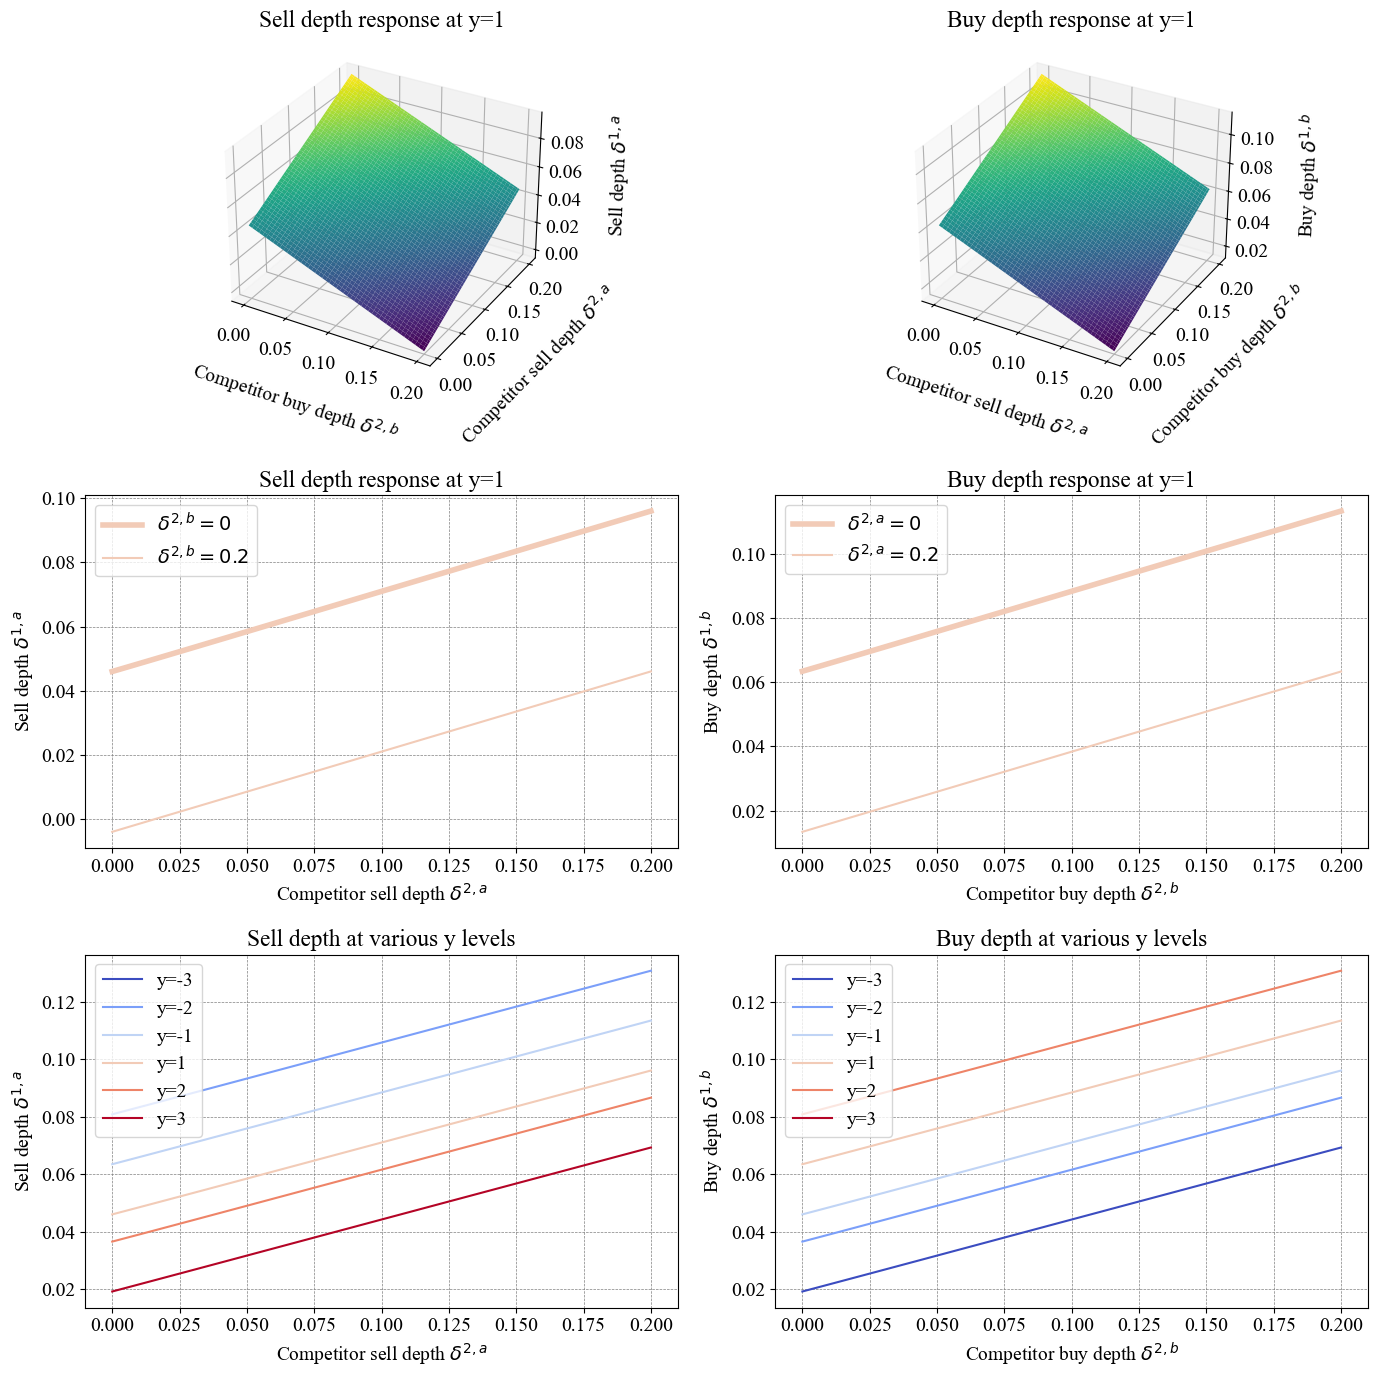

In [51]:
# Update font properties
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})

# Create a colormap with a range of colors from red to blue
colors = plt.cm.coolwarm(np.linspace(0, 1, 6))

# Create the figure
fig = plt.figure(figsize=(14, 14))  # Increased figure size for better readability

# Plotting the 3D surfaces for sell depth
ax1 = fig.add_subplot(3, 2, 1, projection='3d')
surface1 = ax1.plot_surface(Y_delta_b_2, X_delta_a_2, delta_a_star[3, :, :], cmap='viridis', edgecolor='none')
ax1.set_title('Sell depth response at y=1')
ax1.set_ylabel('Competitor sell depth $\delta^{2,a}$', labelpad=15)
ax1.set_xlabel('Competitor buy depth $\delta^{2,b}$', labelpad=15)
ax1.set_zlabel('Sell depth $\delta^{1,a}$', labelpad=15)
ax1.set_facecolor((1, 1, 1))  # Change background to white

# Plotting the 3D surfaces for buy depth
ax2 = fig.add_subplot(3, 2, 2, projection='3d')
surface2 = ax2.plot_surface(X_delta_a_2, Y_delta_b_2, delta_b_star[3, :, :], cmap='viridis', edgecolor='none')
ax2.set_title('Buy depth response at y=1')
ax2.set_xlabel('Competitor sell depth $\delta^{2,a}$', labelpad=15)
ax2.set_ylabel('Competitor buy depth $\delta^{2,b}$', labelpad=15)
ax2.set_zlabel('Buy depth $\delta^{1,b}$', labelpad=15)
ax2.set_facecolor((1, 1, 1))  # Change background to white

# 2D plots for varying competitor depths at different inventory levels
ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(delta_a_2, delta_a_star[3, 0, :], label='$\delta^{2,b}=0$', color=colors[3],linewidth=4)
ax3.plot(delta_a_2, delta_a_star[3, -1, :], label='$\delta^{2,b}=0.2$', color=colors[3])
ax3.set_title('Sell depth response at y=1')
ax3.set_xlabel('Competitor sell depth $\delta^{2,a}$')
ax3.set_ylabel('Sell depth $\delta^{1,a}$')
ax3.legend()
ax3.grid(True, color='gray', linestyle='--', linewidth=0.5)

ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(delta_b_2, delta_b_star[3, :, 0], label='$\delta^{2,a}=0$', color=colors[3], linewidth=4)
ax4.plot(delta_b_2, delta_b_star[3, :, -1], label='$\delta^{2,a}=0.2$', color=colors[3])
ax4.set_title('Buy depth response at y=1')
ax4.set_xlabel('Competitor buy depth $\delta^{2,b}$')
ax4.set_ylabel('Buy depth $\delta^{1,b}$')
ax4.legend()
ax4.grid(True, color='gray', linestyle='--', linewidth=0.5)

# 2D plots for varying competitor depths at different inventory levels
ax5 = fig.add_subplot(3, 2, 5)
for i, y in enumerate(y_test_range):
    ax5.plot(delta_a_2, delta_a_star[i, 0, :], label=f'y={y}', color=colors[i])
ax5.set_title('Sell depth at various y levels')
ax5.set_xlabel('Competitor sell depth $\delta^{2,a}$')
ax5.set_ylabel('Sell depth $\delta^{1,a}$')
ax5.legend()
ax5.grid(True, color='gray', linestyle='--', linewidth=0.5)

ax6 = fig.add_subplot(3, 2, 6)
for i, y in enumerate(y_test_range):
    ax6.plot(delta_b_2, delta_b_star[i, :, 0], label=f'y={y}', color=colors[i])
ax6.set_title('Buy depth at various y levels')
ax6.set_xlabel('Competitor buy depth $\delta^{2,b}$')
ax6.set_ylabel('Buy depth $\delta^{1,b}$')
ax6.legend()
ax6.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('Varying_competing_depth_Model_1_a.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
phi1 = 10**(-2)
alpha1 = 10**(-1)
kappa1= 10
hat_y1 = 0

delta_a_2=0.01;
delta_b_2=0.01;

time_steps = 100  # Number of time steps to evaluate
t_grid = np.linspace(0, T, time_steps)
y_test_range=[-3,-2,-1,1,2,3]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_1 = np.zeros((len(y_test_range),len(t_grid)))
delta_a_star_1 = np.zeros((len(y_test_range),len(t_grid)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, t in enumerate(t_grid):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_1[i,j], delta_a_star_1[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [ ]:
phi11 = np.linspace(10**(-1),10**(-2))
t=t_grid[-1]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_2 = np.zeros((len(y_test_range),len(phi11)))
delta_a_star_2 = np.zeros((len(y_test_range),len(phi11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, phi in enumerate(phi11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_2[i,j], delta_a_star_2[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [ ]:
alpha11 = np.linspace(10**(-0),10**(-1)) # No terminal penalty
t=t_grid[-1]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_3 = np.zeros((len(y_test_range),len(alpha11)))
delta_a_star_3 = np.zeros((len(y_test_range),len(alpha11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, alpha in enumerate(alpha11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_3[i,j], delta_a_star_3[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha,phi1,kappa1,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [ ]:
kappa11= np.linspace(1,30)
t=t_grid[-1]
# Storing results for each time point (x-coordinate) and y (y-coordinate)
delta_b_star_4 = np.zeros((len(y_test_range),len(kappa11)))
delta_a_star_4 = np.zeros((len(y_test_range),len(kappa11)))
# Compute W(t) for each time point
for i,y_test in enumerate(y_test_range):
    for j, kappa in enumerate(kappa11):
        x_test=y_test
        z_test=x_test/y_test
        m2_1=x_test*y_test;
        z_2_test=z_test
        S=z_test
        
        delta_b_star_4[i,j], delta_a_star_4[i,j] = optimal_controls(t,T,
                     N_1,zeta,
                     lambda_a,lambda_b,alpha1,phi1,kappa,
                     Y_1,hat_y1,m2_1,y_test,
                     S,z_2,delta_a_2,delta_b_2)

In [ ]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(14, 14))


plt.subplot(2,4,1)
plt.plot(t_grid,delta_a_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_a_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_a_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_a_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_a_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_a_star_1[0,:],'y',label='y=-3')
plt.ylabel('Sell depth $\delta^{1,a}$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,5)
plt.plot(t_grid,delta_b_star_1[5,:],'b',label='y=3')
plt.plot(t_grid,delta_b_star_1[4,:],'g',label='y=2')
plt.plot(t_grid,delta_b_star_1[3,:],'r',label='y=1')
plt.plot(t_grid,delta_b_star_1[2,:],'c',label='y=-1')
plt.plot(t_grid,delta_b_star_1[1,:],'violet',label='y=-2')
plt.plot(t_grid,delta_b_star_1[0,:],'y',label='y=-3')
plt.xlabel('Time (s)')
plt.ylabel('Buy depth $\delta^{1,b}$');
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,2)
plt.plot(phi11,delta_a_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_a_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_a_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_a_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_a_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_a_star_2[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,6)
plt.plot(phi11,delta_b_star_2[5,:],'b',label='y=3')
plt.plot(phi11,delta_b_star_2[4,:],'g',label='y=2')
plt.plot(phi11,delta_b_star_2[3,:],'r',label='y=1')
plt.plot(phi11,delta_b_star_2[2,:],'c',label='y=-1')
plt.plot(phi11,delta_b_star_2[1,:],'violet',label='y=-2')
plt.plot(phi11,delta_b_star_2[0,:],'y',label='y=-3')
plt.xlabel('$\\phi^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,3)
plt.plot(alpha11,delta_a_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_a_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_a_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_a_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_a_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_a_star_3[0,:],'y',label='y=-3')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,7)
plt.plot(alpha11,delta_b_star_3[5,:],'b',label='y=3')
plt.plot(alpha11,delta_b_star_3[4,:],'g',label='y=2')
plt.plot(alpha11,delta_b_star_3[3,:],'r',label='y=1')
plt.plot(alpha11,delta_b_star_3[2,:],'c',label='y=-1')
plt.plot(alpha11,delta_b_star_3[1,:],'violet',label='y=-2')
plt.plot(alpha11,delta_b_star_3[0,:],'y',label='y=-3')
plt.xlabel('$\\alpha^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.subplot(2,4,4)
plt.plot(kappa11,delta_a_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_a_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_a_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_a_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_a_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_a_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02])  # Set specific y-axis ticks


plt.subplot(2,4,8)
plt.plot(kappa11,delta_b_star_4[5,:],'b',label='y=3')
plt.plot(kappa11,delta_b_star_4[4,:],'g',label='y=2')
plt.plot(kappa11,delta_b_star_4[3,:],'r',label='y=1')
plt.plot(kappa11,delta_b_star_4[2,:],'c',label='y=-1')
plt.plot(kappa11,delta_b_star_4[1,:],'violet',label='y=-2')
plt.plot(kappa11,delta_b_star_4[0,:],'y',label='y=-3')
plt.legend(loc='center right')
plt.xlabel('$\\kappa^1$')
#plt.ylim(-1, 1)  # Set the limits of y-axis
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
#plt.yticks([0,0.005, 0.01, 0.015,0.02]);  # Set specific y-axis ticks

plt.savefig('General analysis Model 1.a with competing depths.png', format='png', dpi=300, bbox_inches='tight')